In [1]:
import os
import sys
while not os.getcwd().endswith('ml'):
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import spacy
import random
import string
from collections import defaultdict
from spacy.util import minibatch, compounding
from spacy.lang.en import English
from kaggle_problems.tweet_sentiment_extraction.common import *

from libs.nlp.ner.ner import NER
from helpers.word2vec.converter import *

In [3]:
MAIN_PART_LABEL = 'MAIN_PART_LABEL'

In [4]:
train = pd.read_csv("kaggle_problems/tweet_sentiment_extraction/train.csv")
test = pd.read_csv("kaggle_problems/tweet_sentiment_extraction/test.csv")

train.dropna(inplace=True)
train.reset_index(drop=True, inplace=True)
test.dropna(inplace=True)
test.reset_index(drop=True, inplace=True)

tokenize_nlp = English()

In [5]:
def preprocessing_column(column):
    #column = column.apply(lambda x: ''.join([i for i in x if (i.isalpha() or i == ' ')]))
    #column = column.apply(lambda x: re.sub(' +', ' ', x))
    
    #column = column.apply(lambda x: x[1:] if x.startswith(' ') else x)
    #column = column.apply(lambda x: x[:-1] if x.endswith(' ') else x)
    
    return column

def preprocessing(data):
    data.text = preprocessing_column(data.text)
    data['text_words'] = data['text'].apply(lambda x: list([str(i) for i in tokenize_nlp(x)]))
    data['text_cnt_words'] = data['text'].apply(lambda x: len(list(tokenize_nlp(x))))
    
    if 'selected_text' in data.columns:
        data.selected_text = preprocessing_column(data.selected_text)
        data['selected_text_words'] = data['selected_text'].apply(lambda x: list([str(i) for i in tokenize_nlp(x)]))
        data['selected_text_cnt_words'] = data['selected_text'].apply(lambda x: len(list(tokenize_nlp(x))))
    
    return data

In [6]:
train = preprocessing(train)
test = preprocessing(test)



In [7]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    while text.startswith(' '):
        text = text[1:]
    while text.endswith(' '):
        text = text[:-1]
    return text

train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))

In [8]:
train.sample(1)

,textID,text,selected_text,sentiment,text_words,text_cnt_words,selected_text_words,selected_text_cnt_words
14089,dcefaf27f5,dont we all,dont we all,neutral,"[ , Don`t, we, all, !]",5,"[Don`t, we, all, !]",4


In [9]:
def is_subarray(text, selected_text):
    for i in range(len(text) - len(selected_text) + 1):
        
        if text[i: i + len(selected_text)] == selected_text:
            return True
    return False

In [10]:
train['is_subarray'] = train.apply(lambda x: is_subarray(x.text_words, x.selected_text_words), axis=1)

In [11]:
train.is_subarray.describe()

count     27480
unique        2
top        True
freq      25480
Name: is_subarray, dtype: object

### Гипотеза что расстояние джакара между selected_texts and texts маленькое для text_cnt_words < X

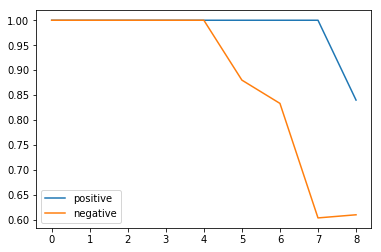

In [13]:
jacard_dist = defaultdict(list)
for sentiment in ['positive', 'negative']:
    for i in range(1, 10):
        msk = (train['text_cnt_words'] <= i) & (train['sentiment'] == sentiment)
        texts = train[msk]['text']
        selected_texts = train[msk]['selected_text']
        jacard_dist[sentiment].append(arr_jaccard(texts, selected_texts))
        
for sentiment in ['positive', 'negative']:
    plt.plot(jacard_dist[sentiment], label=sentiment)
plt.legend()
plt.show()

Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_positive'
Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_negative'


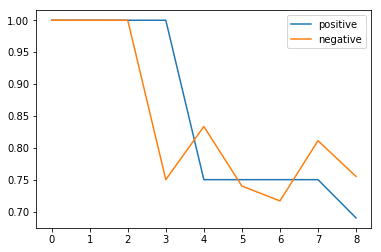

In [14]:
jacard_dist = defaultdict(list)
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    for i in range(1, 10):
        msk = (train['text_cnt_words'] <= i) & (train['sentiment'] == sentiment)
        
        predict_selected_texts = predict(model, train[msk])
        selected_texts = train[msk].selected_text.to_numpy()

        jacard_dist[sentiment].append(arr_jaccard(selected_texts, predict_selected_texts))
        
        
for sentiment in ['positive', 'negative']:
    plt.plot(jacard_dist[sentiment], label=sentiment)
plt.legend()
plt.show()

In [15]:
def df_to_spacy_format(data):
    data.reset_index(drop=True, inplace=True)
    spacy_data  = [0] * len(data)
    for ind, line in data.iterrows():
#         print("-" * 100)
#         print(ind)
        start_word, end_word = get_start_end_char(line)
        spacy_data[ind] = (
            line['text'], 
            {"entities": [(start_word, end_word, MAIN_PART_LABEL)]}
        )
        
        #tokens = tokenize_nlp(line['text'])
#         print([t.text for t in tokens])
#         print(0, start_word, end_word, len(line['text']))
#         print(line['text'][start_word:end_word])
#         print(line['selected_text'])
#         print(spacy.gold.biluo_tags_from_offsets(tokenize_nlp.make_doc(line['text']), [(start_word, end_word, MAIN_PART_LABEL)]))
#         print("-" * 100)
    return spacy_data


### Training

In [16]:
for sentiment in ['positive', 'negative', 'neutral']:
    print("Training for {}".format(sentiment))
    print("-" * 100)
    model = NER(evaluate_score=evaluate_score)
    
    spacy_train_pos = df_to_spacy_format(train[train['sentiment'] == sentiment])
    train_los, validation_los = model.train(spacy_train_pos, n_iter=30)
    model.save_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    pickle.dump(train_los, open("kaggle_problems/tweet_sentiment_extraction/data/baseline/train_los_{}.pkl".format(sentiment), 'wb'))
    pickle.dump(validation_los, open("kaggle_problems/tweet_sentiment_extraction/data/baseline/validation_los_{}.pkl".format(sentiment), 'wb'))
    
    print("-" * 100)

Training for positive
----------------------------------------------------------------------------------------------------
Created blank 'en' model


/Users/skrrydg/anaconda3/lib/python3.7/site-packages/spacy/language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
100%|██████████| 30/30 [00:04<00:00,  6.12it/s]


Saved model to kaggle_problems/tweet_sentiment_extraction/models/ner_positive
----------------------------------------------------------------------------------------------------
Training for negative
----------------------------------------------------------------------------------------------------
Created blank 'en' model


  0%|          | 0/30 [00:00<?, ?it/s]/Users/skrrydg/anaconda3/lib/python3.7/site-packages/spacy/language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "i lost all my friends im alone and sleepyi wanna g..." with entities "[(0, 41, 'MAIN_PART_LABEL')]". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)
100%|██████████| 30/30 [00:06<00:00,  4.83it/s]


Saved model to kaggle_problems/tweet_sentiment_extraction/models/ner_negative
----------------------------------------------------------------------------------------------------
Training for neutral
----------------------------------------------------------------------------------------------------
Created blank 'en' model


100%|██████████| 30/30 [00:08<00:00,  3.66it/s]

Saved model to kaggle_problems/tweet_sentiment_extraction/models/ner_neutral
----------------------------------------------------------------------------------------------------


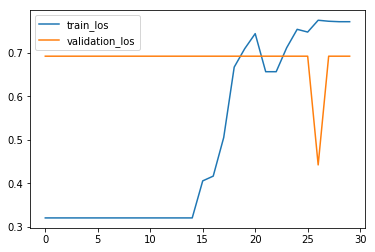

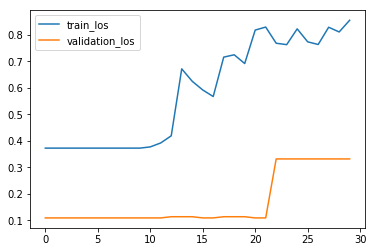

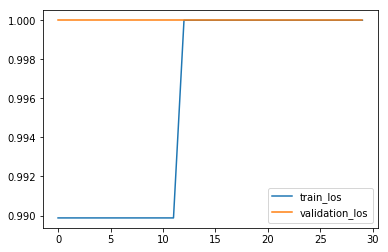

In [17]:
for sentiment in ['positive', 'negative', 'neutral']:
    train_los = pickle.load(open("kaggle_problems/tweet_sentiment_extraction/data/baseline/train_los_{}.pkl".format(sentiment), 'rb'))
    validation_los =pickle.load(open("kaggle_problems/tweet_sentiment_extraction/data/baseline/validation_los_{}.pkl".format(sentiment), 'rb'))

    plt.plot(train_los, label='train_los')
    plt.plot(validation_los, label='validation_los')
    plt.legend()
    plt.show()

In [18]:
print(train_los, validation_los)

[0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 0.9898785425101214, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


### Predict on train

In [19]:
prediction = {}
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    
    spacy_train_pos = df_to_spacy_format(train[train['sentiment'] == sentiment])
    
    texts, annotations = zip(*spacy_train_pos)
    annotations = [annotation.get('entities') for annotation in annotations]
    y_predict = model.predict(texts)
    
    print(evaluate_score(texts, annotations, y_predict))

Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_positive'
0.7617068117068116
Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_negative'
0.79087584528761


### Predict on test

In [20]:
result_df = pd.DataFrame(columns=['textID', 'selected_text'])
for sentiment in ['positive', 'negative']:
    model = NER()
    model.load_model('kaggle_problems/tweet_sentiment_extraction/models/ner_{}'.format(sentiment))
    
    predict_selected_texts = predict(model, test[test['sentiment'] == sentiment])
    
    result_df = result_df.append(
        pd.DataFrame(
            data={'textID': test[test['sentiment'] == sentiment].textID.to_numpy(),
                  'selected_text': predict_selected_texts}, 
            columns=['textID', 'selected_text'],
        )
    )
    
result_df = result_df.append(
    pd.DataFrame(
        data={'textID': test[test['sentiment'] == 'neutral'].textID.to_numpy(),
              'selected_text': test[test['sentiment'] == 'neutral'].text.to_numpy()}, 
        columns=['textID', 'selected_text'],
    )
)
result_df = result_df.set_index('textID')


Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_positive'
Created blank 'en' model
Loaded model 'kaggle_problems/tweet_sentiment_extraction/models/ner_negative'


In [21]:
result_df.to_csv('kaggle_problems/tweet_sentiment_extraction/submissions/{}'.format('baseline_ner'))

In [22]:
!jupyter nbconvert --to script kaggle_problems/tweet_sentiment_extraction/baseline.ipynb

[NbConvertApp] Converting notebook kaggle_problems/tweet_sentiment_extraction/baseline.ipynb to script
[NbConvertApp] Writing 8273 bytes to kaggle_problems/tweet_sentiment_extraction/baseline.py
